In [1]:
import numpy as np
import os
import mne
import pickle
import pandas as pd
from mat73 import loadmat
import matplotlib.pyplot as plt
import osl
import yaml

In [2]:
path = '/well/woolrich/projects/disp_csaky/opm_lukas/osl_mark/raw_preproc.fif'
raw = mne.io.read_raw_fif(path, preload=True)
raw_old = mne.io.read_raw_fif(path, preload=True)

Opening raw data file /well/woolrich/projects/disp_csaky/opm_lukas/osl_mark/raw_preproc.fif...


<ipython-input-2-3bdc04d14fa0>:2: RuntimeWarning: This filename (/well/woolrich/projects/disp_csaky/opm_lukas/osl_mark/raw_preproc.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Isotrak not found
    Range : 0 ... 3336239 =      0.000 ...  2780.199 secs
Ready.
Reading 0 ... 3336239  =      0.000 ...  2780.199 secs...
Opening raw data file /well/woolrich/projects/disp_csaky/opm_lukas/osl_mark/raw_preproc.fif...


<ipython-input-2-3bdc04d14fa0>:3: RuntimeWarning: This filename (/well/woolrich/projects/disp_csaky/opm_lukas/osl_mark/raw_preproc.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_old = mne.io.read_raw_fif(path, preload=True)


Isotrak not found
    Range : 0 ... 3336239 =      0.000 ...  2780.199 secs
Ready.
Reading 0 ... 3336239  =      0.000 ...  2780.199 secs...


Setting 52800 of 3336240 (1.58%) samples to NaN, retaining 3283440 (98.42%) samples.
Effective window size : 16.667 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.4s finished


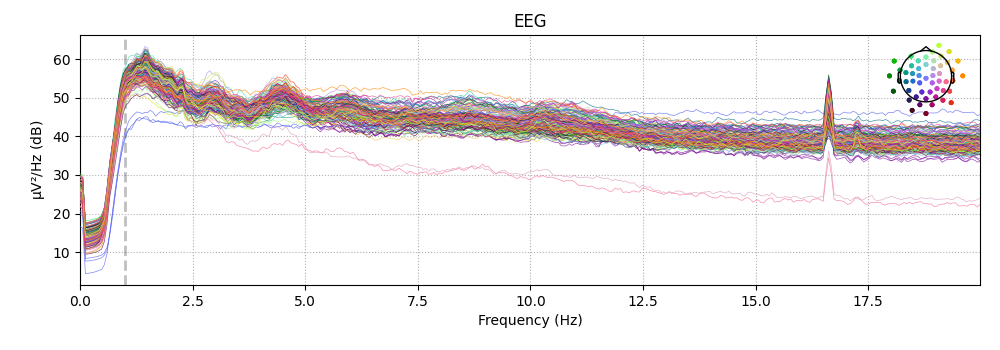

In [9]:
%matplotlib widget
raw.plot_psd(fmax=20, n_fft=20000)
e=0

In [ ]:
lang_channels = ['LR', 'LF', 'LE', 'LN', 'KG', 'LM', 'KI', 'KF', 'KH', 'LA',
                 'FR', 'FV', 'FU', 'FS', 'G2', 'G0', 'HQ', 'HE', 'FX', 'I4']

# extract indices from raw.ch_names if lang_channels name is in the string of raw.ch_names
lang_indices = [str(i) for i, s in enumerate(raw.ch_names) if any(xs in s for xs in lang_channels)]

In [ ]:
print(','.join(lang_indices))

In [ ]:
raw.plot_sensors(show_names=True)

In [4]:
channels = pd.read_csv('/well/woolrich/projects/disp_csaky/opm_lukas/20221019_085012_channels.tsv', sep='\t')

In [5]:
# get Ox, Oy, Oz orientations from channels.tsv based on raw.ch_names
Ox = channels.loc[channels['name'].isin(raw.ch_names), 'Ox'].values
Oy = channels.loc[channels['name'].isin(raw.ch_names), 'Oy'].values
Oz = channels.loc[channels['name'].isin(raw.ch_names), 'Oz'].values

ors = np.vstack((Ox, Oy, Oz)).T

In [6]:
# eye(length(ors)) - ors*pinv(ors)
eye = np.eye(len(ors))
pinv = np.linalg.pinv(ors)
mfc = eye - ors @ pinv

In [7]:
# apply mfc to the raw object through raw.apply_function()
fun = lambda x: mfc @ (x - np.mean(x, axis=1, keepdims=True))
raw.apply_function(fun, channel_wise=False)

<Raw | raw_preproc.fif, 152 x 3336240 (2780.2 s), ~3.78 GB, data loaded>

In [ ]:
mne.set_config('MNE_BROWSE_RAW_SIZE', '16,9')

In [8]:
raw.save('/well/woolrich/projects/disp_csaky/opm_lukas/raw_preproc_mark_mfc.fif', overwrite=True)

Writing /well/woolrich/projects/disp_csaky/opm_lukas/raw_preproc_mark_mfc.fif


<ipython-input-8-a9be2e2d4907>:1: RuntimeWarning: This filename (/well/woolrich/projects/disp_csaky/opm_lukas/raw_preproc_mark_mfc.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save('/well/woolrich/projects/disp_csaky/opm_lukas/raw_preproc_mark_mfc.fif', overwrite=True)


Closing /well/woolrich/projects/disp_csaky/opm_lukas/raw_preproc_mark_mfc.fif
[done]


In [ ]:
raw.get_data(picks='eeg').shape

In [ ]:
raw.info

In [ ]:
# check whether the mfc is applied correctly
%matplotlib inline
raw.plot(n_channels=80, start=100, duration=100, scalings=dict(eeg=1e3))
raw_old.plot(n_channels=80, start=100, duration=100, scalings=dict(eeg=1e3))